## A/B Testing: A mock example
In this notebook, I'll go over an example of analysing an A/B test, from formulating a hypothesis, testing it, and interpretting the results.  The data is coming from a [Kaggle dataset](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv), which contains the results of an A/B test for two different designs of a webpage (Old page : Control(A), New page : Treatment(B)).

### Scenario
In this mock example, I'm going to imagine the company is testing a **new webpage** that is **expected to increase conversion rate** for our business (i.e., viewer becomes customer). I've been informed the annual, average converstion rate for the current page is about **12%** and the development team is targeting an increase of two percentage points moving the **conversion rate to 14%**.

### Table of Contents:
1. Designing the experiment
2. Collecting and preparing the data
3. Visualizing the results
4. Testing the hypothesis
5. What does it all mean

---------------

## 1. Designing the Experiment

#### Formulating the Hypothesis
Since I don't know if the new design will perform better or worse than the current design, I'll conduct a **two-tailed test**:


  $H_{0} : p = p_{0}$  
  $H_{\alpha} : p \neq p_{0}$


where $p$ and $p_{0}$ stand for the conversion rate of the new and old design, respectively. In common terms, the hypothesis are stated as:

Null Hypothesis: The new webpage will not result in a different conversion rate.
<br>Alternate Hypothesis: The new webpage will result in a different converstion rate.

I'll set a **confidence level of 95%**:


  $\alpha = 0.05$


Now to determine the sample size by performing a power analysis with the power ($1-\beta$) of the test set at 0.8. This will result in an 80% probability that I'll find the statistical difference between the control (A) and treatment (B) group.


In [1]:
# Import packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline


In [2]:

# Determining required observations for each group

# calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.12, 0.14)

# calculating sample size
required_n = sms.NormalIndPower().solve_power(
                effect_size,
                power=0.8,
                alpha=0.05,
                ratio=1
                )

# roundup to next whole number
required_n = ceil(required_n)

# output sample size
print(f"I need at least {required_n} observations for each group.")


I need at least 4433 observations for each group.


---

## 2. Collecting and preparing the data
Wonderful!  So now I know the sample size, I can collect the data.  In real life, I would run the experiment until I had collected enough observations for each group.  However, since this is a mock-up example, I will load the Kaggle dataset previously downloaded. Then I will randomly sample the required number of observations from each grouping.

*Let's get to it!*

In [3]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:

# Make a cross-tab report to see ensure our control group is only seeing the old page and vice-a-versa
pd.crosstab(df['group'], df['landing_page'])


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:

# Looks like there is a population that has seen both old and new pages.
# Checking to see if the same user was sampled twice.
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f"There are {multi_users} users that appear multiple times.")


There are 3894 users that appear multiple times.


The cross-tab above shows 3,893 users who voted on multiple webpages and this analysis shows 3,894.  I thnk it is safe to assume these are all the users who voted twice.  Given that there are over 294,000 samples in our data set and we only need 8,866 for our experiment...I think it is safe to remove these.

In [8]:

users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f"The updated dataset no has {df.shape[0]} entries.")


The updated dataset no has 286690 entries.


### Sampling

Time to randomly sample our observations for each group.

In [9]:

# sample for each treatment group
control = df[df['group'] == 'control'].sample(n = required_n, random_state = 42)
treatment = df[df['group'] == 'treatment'].sample(n = required_n, random_state = 42)

# append the two samples together into one dataframe
ab_test = pd.concat([control, treatment], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test


,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
8861,651827,2017-01-09 18:15:23.956908,treatment,new_page,0
8862,766249,2017-01-17 09:02:39.358863,treatment,new_page,0
8863,913902,2017-01-04 05:14:56.214319,treatment,new_page,0
8864,858371,2017-01-12 00:40:04.537201,treatment,new_page,0


In [10]:

ab_test['group'].value_counts()


control      4433
treatment    4433
Name: group, dtype: int64

---

## 3. Visualizing the results

First I'm going to calculate some basic stats to get an idea of what the samples look like.

In [11]:

# created grouped dataframe
conversion_rates = ab_test.groupby('group')['converted']

# standard deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)

# standard error of the proportion
se_p = lambda x: stats.sem(x, ddof=0)

# build the summary table
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['Conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')


C:\Users\Nercob\anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Nercob\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Nercob\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Conversion_rate,std_deviation,std_error
group,,,
control,0.113,0.316,0.005
treatment,0.127,0.333,0.005


Based on these stats alone, it looks like the treatment group performed slightly better at 1.4 percentage points higher conversion rate.  Although, still below our target of 2 percentage points improvement.

Also appears, our conversion rate on our control group is lower than what I was told to expect for the annual average of 12%. Hmm.... Let's plot this.

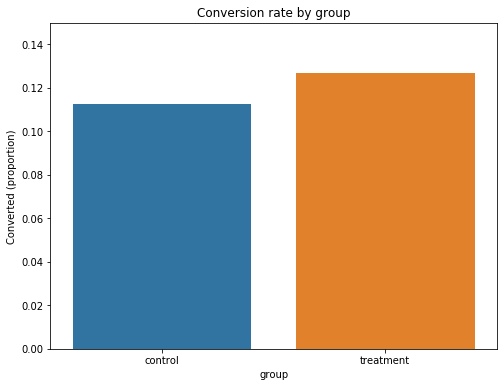

In [12]:

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0,0.15)
plt.title('Conversion rate by group')
plt.ylabel('Converted (proportion)');

plt.show()


---

## 4. Testing the hypothesis

In [13]:

# get the p-value (z-test)
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [14]:

# set variables for the group results
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']


In [15]:

# set variables for counts of each groups responses and the sum of successful conversions
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
# total number of observations between tests
nobs = [n_con, n_treat]

# calculate statistics
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

# print results
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -2.09
p-value: 0.036
ci 95% for control group: [0.103, 0.122]
ci 95% for treatment group: [0.117, 0.137]


---

## 5. What does it all mean

Since the $p$-value=0.036 is below the $\alpha$=0.05, I will reject the null hypothesis and accept the alternate hypothesis, which means the new webpage does lead to a higher conversion rates than the old.  

However, it is important to keep in mind that the conversion reates from both groups were lower than:
1. the assumed annual conversion rate (12%),
2. the targeted conversion rate (14% or two percentage points higher than assumed conversion rate).

Further, if looking at the confidence interval for the treatment group (11.7% to 13.7%), we see that it does encompass the originally assumed conversion rate and is just shy of the target rate.

What this tells me is that, with 95% confidence, there is an 80% probability the company can expect an almost one percentage point improvement in conversion rates over the existing design (12.7% vs 12%), but there is yet more room to optimize the conversion rate and a new design should be reserached. Furthermore, if there are no additional cost constraints, it is my recommendation to deploy the refreshed design for incremental improvements while a second refresh is in development.